## Parkeergarages - Data Analyse

1. Laad en bekijk de data
2. Plot de parkeergarages
3. Laat zien dat transaction_id geen informatie bevat
4. Groepeer de data per garage, per dag

In [65]:
#%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium #note: will not run in explorer

In [3]:
path=''
parking_transactions=pd.read_csv(path+'parkeerdata/leeuwarden_garage_parking_transactions.csv',sep=";")

In [4]:
parking_locations=pd.read_csv(path+'parkeerdata/leeuwarden_garage_parking_garage_gps.csv',sep=";",decimal=",")

In [5]:
print("parking_transactions",parking_transactions.shape)
print("parking_locations",parking_locations.shape)

parking_transactions (3380160, 9)
parking_locations (5, 5)


In [6]:
parking_transactions.head()

,garage_id,card_type_id,transaction_id,start_parking_dt,end_parking_dt,pay_parking_dt,entry_station_cid,pay_station_cid,exit_station_cid
0,36,220,2912536,1-1-2016 00:14,1-1-2016 06:17,1-1-2016 06:14,989.0,998.0,992.0
1,36,220,2912538,1-1-2016 00:27,1-1-2016 05:11,1-1-2016 05:09,989.0,998.0,992.0
2,36,220,2912537,1-1-2016 00:27,1-1-2016 05:56,1-1-2016 05:52,988.0,998.0,993.0
3,36,220,2912539,1-1-2016 00:28,1-1-2016 08:14,1-1-2016 08:06,989.0,998.0,992.0
4,36,220,2912540,1-1-2016 00:34,1-1-2016 04:09,1-1-2016 04:03,989.0,998.0,992.0


In [7]:
parking_locations.head()

,garage_id,garage_nm,capacity_value,latitude,longitude
0,39,Oldehove,525,53.203227,5.789788
1,40,Oosterstraat,250,53.201402,5.801438
2,36,Zaailand,720,53.199224,5.795601
3,37,Klanderij,625,53.197996,5.798296
4,38,Hoeksterend,390,53.205792,5.802553


## Plot de locaties van de parkeergarages

In [8]:
folium_map = folium.Map(location=[np.mean(parking_locations.latitude[:]), np.mean(parking_locations.longitude[:])],
                        zoom_start=14, width = 500, height = 300, control_scale = True)
for i in range(len(parking_locations)):
    folium.Marker([parking_locations.latitude[i], parking_locations.longitude[i]],
                  popup = parking_locations.garage_nm[i], icon=folium.Icon(icon='car', prefix='fa')).add_to(folium_map)
folium_map

## Laat zien dat transaction_id geen informatie bevat

We maken 1 dataset met alle transacties uit abonnementen (card_type_id = 221), en tellen de unieke transaction_id's voor een bepaalde garage (in dit geval, garage 40, die heeft de minste beschikbare plaatsen)

In [11]:
parking_abbo40 = parking_transactions.loc[np.logical_and(parking_transactions.card_type_id == 221,parking_transactions.garage_id == 40)]
unique_abbo40 = set()
for ID in parking_abbo40.transaction_id:
    unique_abbo40.add(ID)
print("Aantal unieke transaction_id's: ", len(unique_abbo40))
print("Aantal regels in parking_abbo40: ", len(parking_abbo40))

Aantal unieke transaction_id's:  91497
Aantal regels in parking_abbo40:  91497


Deze waarden zijn hetzelfde, hetgeen bewijs geeft dat de mensen met een abonnement niet te achterhalen zijn. Voor de zekerheid doen we nu hetzelfde bij de losse parkeerkaarten:

In [12]:
parking_los40 = parking_transactions.loc[np.logical_and(parking_transactions.card_type_id == 220,parking_transactions.garage_id == 40)]
unique_los40 = set()
for ID in parking_los40.transaction_id:
    unique_los40.add(ID)
print("Aantal unieke transaction_id's: ", len(unique_los40))
print("Aantal regels in parking_los40: ", len(parking_los40))

Aantal unieke transaction_id's:  49143
Aantal regels in parking_los40:  49143


We nemen aan dat dit voor alle parkeergarages geldt. In de volledige dataset zitten wel transaction_id's die vaker voorkomen, maar de id's die hetzelfde zijn zullen niet uit dezelfde parkeergarage komen.

De transactie id's bevatten dus geen informatie.

## Data opschonen en opsplitsen per garage
De data heeft wat nan waarden, wat inhoud dat er auto's in de garage parkeren die er nooit uitgaan. Of andersom.
Die gaan we er uit halen, en de data opslaan per garage.

In [ ]:
transactions = parking_transactions[pd.notnull(parking_transactions.end_parking_dt)]
transactions = transactions[pd.notnull(transactions.start_parking_dt)]

transactions['visit_datetime'] = pd.to_datetime(transactions['start_parking_dt'], format='%d-%m-%Y %H:%M')
transactions['visit_date'] = transactions['visit_datetime'].dt.date
transactions['leave_datetime'] = pd.to_datetime(transactions['end_parking_dt'], format='%d-%m-%Y %H:%M')
transactions['leave_date'] = transactions['leave_datetime'].dt.date

In [ ]:
#Om het werk te verlichten pak ik 3 maanden:
from_datetime="2017-03-01"
to_datetime="2017-06-01"
mask = (transactions['visit_date'] >= from_datetime) & (transactions['leave_date'] <= to_datetime)
parking_data = transactions.loc[mask]


In [ ]:
bezetting_in = parking_data[['visit_datetime', 'garage_id', 'card_type_id', 'transaction_id']]
bezetting_in.columns = ['event_time', 'garage_id', 'card_type_id', 'transaction_id']
#create column in_out representing the incremental change in the garage
bezetting_in['in_out'] = 1

bezetting_out = parking_data[['leave_datetime', 'garage_id', 'card_type_id', 'transaction_id']]
bezetting_out.columns = ['event_time', 'garage_id', 'card_type_id', 'transaction_id']
#create column in_out representing the incremental change in the garage
bezetting_out['in_out'] = -1

# Voeg de twee datasets samen, en sorteer op datum en tijd
bezetting = pd.concat([bezetting_in, bezetting_out])

## Groepeer de data per garage per dag

In [9]:
#maak een datumkolom
parking_transactions['visit_datetime'] = pd.to_datetime(parking_transactions['start_parking_dt'], format='%d-%m-%Y %H:%M')
#'1-1-2016 00:14' 
parking_transactions['visit_date'] = parking_transactions['visit_datetime'].dt.date
parking_transactions.head()

,garage_id,card_type_id,transaction_id,start_parking_dt,end_parking_dt,pay_parking_dt,entry_station_cid,pay_station_cid,exit_station_cid,visit_datetime,visit_date
0,36,220,2912536,1-1-2016 00:14,1-1-2016 06:17,1-1-2016 06:14,989.0,998.0,992.0,2016-01-01 00:14:00,2016-01-01
1,36,220,2912538,1-1-2016 00:27,1-1-2016 05:11,1-1-2016 05:09,989.0,998.0,992.0,2016-01-01 00:27:00,2016-01-01
2,36,220,2912537,1-1-2016 00:27,1-1-2016 05:56,1-1-2016 05:52,988.0,998.0,993.0,2016-01-01 00:27:00,2016-01-01
3,36,220,2912539,1-1-2016 00:28,1-1-2016 08:14,1-1-2016 08:06,989.0,998.0,992.0,2016-01-01 00:28:00,2016-01-01
4,36,220,2912540,1-1-2016 00:34,1-1-2016 04:09,1-1-2016 04:03,989.0,998.0,992.0,2016-01-01 00:34:00,2016-01-01


In [15]:
visitors_per_day = parking_transactions.groupby(['garage_id','visit_date', 'card_type_id'],as_index=False)['transaction_id'].count().rename(columns={'transaction_id':'count_transactions'})
print(len(visitors_per_day))
visitors_per_day.tail()

8256


,garage_id,visit_date,card_type_id,count_transactions
8251,40,2018-04-28,221,1
8252,40,2018-04-29,220,39
8253,40,2018-04-29,221,1
8254,40,2018-04-30,220,26
8255,40,2018-04-30,221,166


In [16]:
visitors_per_day['visit_datetime'] = pd.to_datetime(visitors_per_day['visit_date'])
#create masks for all 10 combinations
mask36220 = ((visitors_per_day['garage_id']==36) & (visitors_per_day['card_type_id'] == 220))
mask36221 = ((visitors_per_day['garage_id']==36) & (visitors_per_day['card_type_id'] == 221))
mask37220 = ((visitors_per_day['garage_id']==37) & (visitors_per_day['card_type_id'] == 220))
mask37221 = ((visitors_per_day['garage_id']==37) & (visitors_per_day['card_type_id'] == 221))
mask38220 = ((visitors_per_day['garage_id']==38) & (visitors_per_day['card_type_id'] == 220))
mask38221 = ((visitors_per_day['garage_id']==38) & (visitors_per_day['card_type_id'] == 221))
mask39220 = ((visitors_per_day['garage_id']==39) & (visitors_per_day['card_type_id'] == 220))
mask39221 = ((visitors_per_day['garage_id']==39) & (visitors_per_day['card_type_id'] == 221))
mask40220 = ((visitors_per_day['garage_id']==40) & (visitors_per_day['card_type_id'] == 220))
mask40221 = ((visitors_per_day['garage_id']==40) & (visitors_per_day['card_type_id'] == 221))

In [ ]:
vpd36220 = visitors_per_day.loc[mask36220]
vpd36221 = visitors_per_day.loc[mask36221]

## Test plot voor event data tussen maart en juni 2017 voor één garage

In [23]:
garage_id = 37
bezetting_sel_37 = pd.read_csv("../data/bezetting2_garage_"+str(garage_id)+".csv",sep=";")
del bezetting_sel_37['Unnamed: 0']
bezetting_sel_37.tail()

,event_time,garage_id,card_type_id,transaction_id,in_out
79833,2017-05-31 21:41:00,37,220,1918056,-1
79834,2017-05-31 22:02:00,37,220,1918027,-1
79835,2017-05-31 22:08:00,37,220,1917682,-1
79836,2017-05-31 22:08:00,37,220,1918061,-1
79837,2017-05-31 22:45:00,37,220,1918063,-1


In [24]:
bezetting_sel_37['total_occupied'] = bezetting_sel_37.in_out.cumsum()
bezetting_sel_37['event_time'] = bezetting_sel_37['event_time'].astype('datetime64[ns]')
max(bezetting_sel_37['total_occupied'])
bezetting_sel_37.tail()

,event_time,garage_id,card_type_id,transaction_id,in_out,total_occupied
79833,2017-05-31 21:41:00,37,220,1918056,-1,4
79834,2017-05-31 22:02:00,37,220,1918027,-1,3
79835,2017-05-31 22:08:00,37,220,1917682,-1,2
79836,2017-05-31 22:08:00,37,220,1918061,-1,1
79837,2017-05-31 22:45:00,37,220,1918063,-1,0


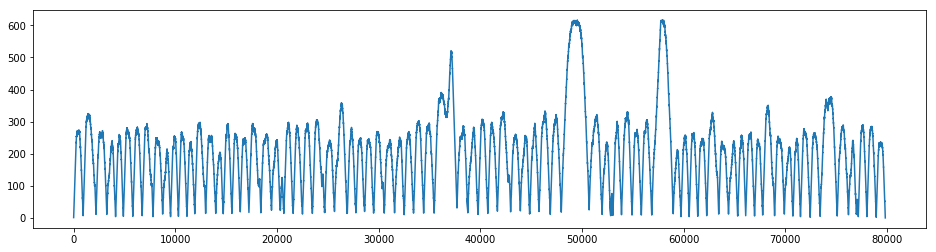

In [8]:
import matplotlib.pyplot as plt
# plot 'total_occupied' on 'event_time'.
fig = plt.figure(figsize=(16, 4)) 
plt.plot(bezetting_sel_37.total_occupied)


Data geplot per event, maar dit is natuurlijk niet lineair. Dus we gaan kijken of het tijdstip op de x-as kan.

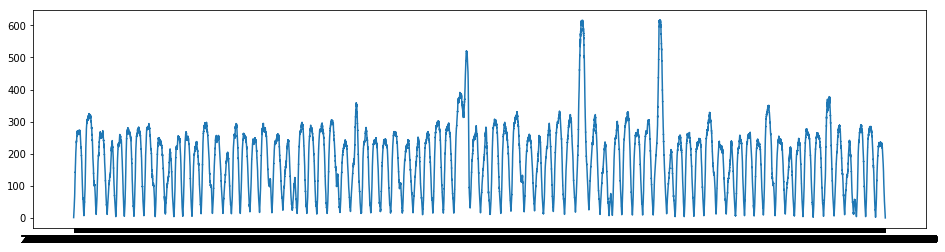

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(16, 4)) 
plt.plot('event_time','total_occupied', data = bezetting_sel_37)

## Hetzelfde voor 7 dagen, parkeergarage 36

In [29]:
garage_id = 36
bezetting_sel_36 = pd.read_csv("../data/bezetting2_garage_"+str(garage_id)+".csv",sep=";")
del bezetting_sel_36['Unnamed: 0']
bezetting_sel_36['total_occupied'] = bezetting_sel_36.in_out.cumsum()
bezetting_sel_36.tail()

,event_time,garage_id,card_type_id,transaction_id,in_out,total_occupied
341997,2017-05-31 23:47:00,36,220,3921854,-1,4
341998,2017-05-31 23:47:00,36,220,3921915,-1,3
341999,2017-05-31 23:48:00,36,220,3921893,-1,2
342000,2017-05-31 23:53:00,36,220,3921889,-1,1
342001,2017-06-01 00:00:00,36,220,3921846,-1,0


In [38]:
# We willen 3 dagen gebruiken
from_datetime="2017-04-01"
to_datetime="2017-04-08"
mask = (bezetting_sel_36['event_time'] >= from_datetime) & (bezetting_sel_36['event_time'] <= to_datetime)
bezetting_sel1_36 = bezetting_sel_36.loc[mask]
bezetting_sel1_36.tail()

,event_time,garage_id,card_type_id,transaction_id,in_out,total_occupied
143730,2017-04-07 23:57:00,36,220,3817581,-1,179
143731,2017-04-07 23:57:00,36,220,3817332,-1,178
143732,2017-04-07 23:58:00,36,220,3817525,-1,177
143733,2017-04-07 23:58:00,36,220,3817085,-1,176
143734,2017-04-07 23:59:00,36,220,3817719,1,177


In [39]:
bezetting_sel1_36['event_time'] = bezetting_sel1_36['event_time'].astype('datetime64[ns]')
max(bezetting_sel1_36['total_occupied'])
bezetting_sel1_36.tail()

C:\Users\verho534\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,event_time,garage_id,card_type_id,transaction_id,in_out,total_occupied
143730,2017-04-07 23:57:00,36,220,3817581,-1,179
143731,2017-04-07 23:57:00,36,220,3817332,-1,178
143732,2017-04-07 23:58:00,36,220,3817525,-1,177
143733,2017-04-07 23:58:00,36,220,3817085,-1,176
143734,2017-04-07 23:59:00,36,220,3817719,1,177


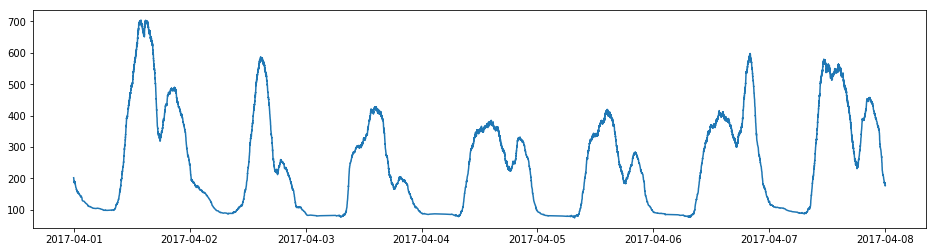

In [40]:
%matplotlib inline
fig = plt.figure(figsize=(16, 4)) 
plt.plot('event_time','total_occupied', data = bezetting_sel1_36)

In [61]:
#to_datetime="2017-04-08"
from_datetime = to_datetime
import datetime
to_datetime = (datetime.datetime.strptime(to_datetime, "%Y-%m-%d") + datetime.timedelta(days=7))
to_datetime = to_datetime.strftime("%Y-%m-%d")
print(to_datetime)

2017-04-15


'15-04-2017'

In [62]:
mask = (bezetting_sel_36['event_time'] >= from_datetime) & (bezetting_sel_36['event_time'] <= to_datetime)
bezetting_sel2_36 = bezetting_sel_36.loc[mask]
bezetting_sel2_36.tail()

,event_time,garage_id,card_type_id,transaction_id,in_out,total_occupied
167528,2017-04-14 23:58:00,36,220,3830826,-1,177
167529,2017-04-14 23:58:00,36,220,3830604,-1,176
167530,2017-04-14 23:58:00,36,220,3830848,-1,175
167531,2017-04-14 23:58:00,36,220,3830840,-1,174
167532,2017-04-14 23:59:00,36,220,3830789,-1,173


In [63]:
bezetting_sel2_36['event_time'] = bezetting_sel2_36['event_time'].astype('datetime64[ns]')
print(max(bezetting_sel2_36['total_occupied']))
bezetting_sel2_36.tail()

706


C:\Users\verho534\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,event_time,garage_id,card_type_id,transaction_id,in_out,total_occupied
167528,2017-04-14 23:58:00,36,220,3830826,-1,177
167529,2017-04-14 23:58:00,36,220,3830604,-1,176
167530,2017-04-14 23:58:00,36,220,3830848,-1,175
167531,2017-04-14 23:58:00,36,220,3830840,-1,174
167532,2017-04-14 23:59:00,36,220,3830789,-1,173


Om de twee op elkaar te plotten, gaan we 1 week afhalen van de datums.

In [67]:
bezetting_sel2_36.event_time =bezetting_sel2_36.event_time - datetime.timedelta(days=7)

C:\Users\verho534\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [68]:
bezetting_sel2_36.head()

,event_time,garage_id,card_type_id,transaction_id,in_out,total_occupied
143735,2017-04-01 00:00:00,36,220,3817566,-1,176
143736,2017-04-01 00:00:00,36,220,3817720,1,177
143737,2017-04-01 00:01:00,36,220,3817721,1,178
143738,2017-04-01 00:01:00,36,220,3817357,-1,177
143739,2017-04-01 00:02:00,36,220,3817500,-1,176


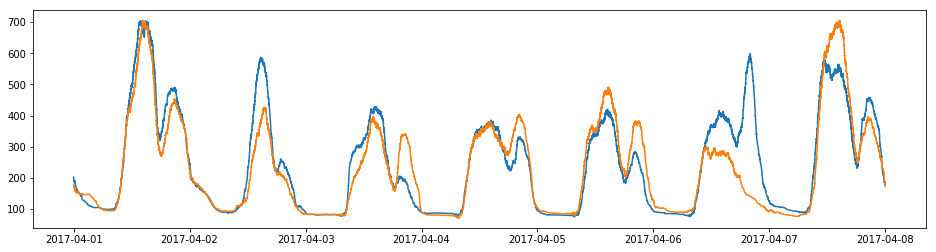

In [69]:
%matplotlib inline
fig = plt.figure(figsize=(16, 4)) 
plt.plot('event_time','total_occupied', data = bezetting_sel1_36)
plt.plot('event_time','total_occupied', data = bezetting_sel2_36)
plt.show()

In [70]:
#to_datetime="2017-04-08"
from_datetime = to_datetime
import datetime
to_datetime = (datetime.datetime.strptime(to_datetime, "%Y-%m-%d") + datetime.timedelta(days=7))
to_datetime = to_datetime.strftime("%Y-%m-%d")
print(to_datetime)

2017-04-22


In [71]:
mask = (bezetting_sel_36['event_time'] >= from_datetime) & (bezetting_sel_36['event_time'] <= to_datetime)
bezetting_sel3_36 = bezetting_sel_36.loc[mask]
bezetting_sel3_36.tail()

,event_time,garage_id,card_type_id,transaction_id,in_out,total_occupied
192312,2017-04-21 23:56:00,36,220,3843659,-1,203
192313,2017-04-21 23:57:00,36,220,3843646,-1,202
192314,2017-04-21 23:57:00,36,220,3843589,-1,201
192315,2017-04-21 23:58:00,36,220,3843620,-1,200
192316,2017-04-21 23:59:00,36,220,3843401,-1,199


In [72]:
bezetting_sel3_36['event_time'] = bezetting_sel3_36['event_time'].astype('datetime64[ns]')
print(max(bezetting_sel3_36['total_occupied']))
bezetting_sel3_36.tail()

714


C:\Users\verho534\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,event_time,garage_id,card_type_id,transaction_id,in_out,total_occupied
192312,2017-04-21 23:56:00,36,220,3843659,-1,203
192313,2017-04-21 23:57:00,36,220,3843646,-1,202
192314,2017-04-21 23:57:00,36,220,3843589,-1,201
192315,2017-04-21 23:58:00,36,220,3843620,-1,200
192316,2017-04-21 23:59:00,36,220,3843401,-1,199


In [75]:
bezetting_sel3_36.event_time = bezetting_sel3_36.event_time - datetime.timedelta(days=14)

C:\Users\verho534\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


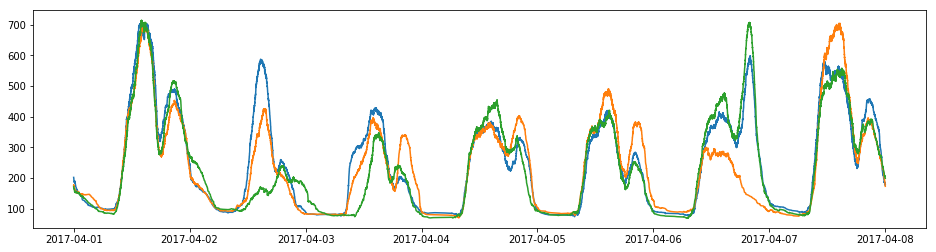

In [76]:
fig = plt.figure(figsize=(16, 4)) 
plt.plot('event_time','total_occupied', data = bezetting_sel1_36)
plt.plot('event_time','total_occupied', data = bezetting_sel2_36)
plt.plot('event_time','total_occupied', data = bezetting_sel3_36)
plt.show()

In [ ]:
weekdata = list()
from_datetime="2017-04-01"
to_datetime="2017-04-08"
for i in range(12):
    mask = (bezetting_sel_36['event_time'] >= from_datetime) & (bezetting_sel_36['event_time'] <= to_datetime)
    bezetting_seltest_36 = bezetting_sel_36.loc[mask]
    bezetting_seltest_36['event_time'] = bezetting_seltest_36['event_time'].astype('datetime64[ns]')
    bezetting_seltest_36.event_time = bezetting_seltest_36.event_time - datetime.timedelta(days = 7 * i)
    print(max(bezetting_seltest_36['total_occupied']))
    weekdata.append(bezetting_sel_36.loc[mask])
    from_datetime = to_datetime
    to_datetime = (datetime.datetime.strptime(to_datetime, "%Y-%m-%d") + datetime.timedelta(days=7))
    to_datetime = to_datetime.strftime("%Y-%m-%d")
weekdata[1]